# Tâche #2 : Classification d'incidents avec un réseau  récurrent et des *embeddings* Spacy

Cette tâche est similaire à la précédente et vous réutilisez les mêmes fichiers d’entraînement, de validation et de test. Cependant, vous devez utiliser des réseaux récurrents pour classifier les textes. Plus particulièrement, vous devez entraîner un réseau de neurones LSTM pour encoder les textes et une couche linéaire pour faire la classification des textes.

Les consignes pour cette tâche sont:
- 	Nom du notebook : rnn.ipynb
- 	Tokenisation : Utilisation de Spacy.
- 	Plongements de mots : Ceux de Spacy.
- 	Normalisation : Aucune normalisation.
- 	Structure du réseau : Un réseau LSTM avec 1 seule couche pour l’encodage de textes. Je vous laisse déterminer la taille de cette couche (à expliquer).
- 	Analyse : Comparer les résultats obtenus avec un réseau unidirectionnel et un réseau bidirectionnel. Si vous éprouvez des difficultés à entraîner les 2 réseaux dans un même notebook, faites une copie et nommez le 2e fichier rnn-bidirectionnel.ipynb.
- 	Expliquez comment les modèles sont utilisés pour faire la classification d’un texte.
- 	Présentez clairement vos résultats et faites-en l’analyse.


Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexes. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code.
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc.
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle.

## 1. Création du jeu de données (*dataset*)

## 1.1 Importaton des librairies


In [ ]:
!python3 -m spacy download en_core_web_md
!pip install --quiet poutyne
!pip install --quiet pytorch-lightning==1.2.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 8.8 MB/s eta 0:00:000m eta 0:00:010:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import spacy
import pandas as pd
from torch import nn
import numpy as np
import json
import torch
import matplotlib.pyplot as plt


from torch import FloatTensor, LongTensor
from poutyne.framework import Experiment
from poutyne import set_seeds
from torch.nn.functional import softmax
from numpy import argmax
from torch import LongTensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim import Adam
from torch import cuda


nlp = spacy.load('en_core_web_md')
device = 'cuda' if cuda.is_available() else 'cpu'
set_seeds(42)

2023-11-23 01:06:29.019225: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 01:06:31.214814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 01:06:33.330295: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1.2 Chargement des jeux de données


In [ ]:
# La fonction load_dataset est utilisée pour lire le contenu des 3 fichiers (train, dev et test)
def load_dataset(filename, base_url):
    with open(base_url + '/'+ filename, 'r') as fp:
        incident_list = json.load(fp)
    return pd.DataFrame(incident_list)

In [ ]:
# Chemin d'accès aux 3 fichiers (train, dev et test)
incidents_train_fn = "incidents_train.json"
incidents_dev_fn = "incidents_dev.json"
incidents_test_fn = "incidents_test.json"
base_url = './nlp/nlp/data'

# Chargement des données
incidents_train = load_dataset(incidents_train_fn, base_url)
incidents_dev = load_dataset(incidents_dev_fn, base_url)
incidents_test = load_dataset(incidents_test_fn, base_url)

# Extraction des données d'entraînement, de développement et de test
X_train, y_train = incidents_train.loc[:, "text"], incidents_train.loc[:, "label"]
X_dev, y_dev = incidents_dev.loc[:, "text"], incidents_dev.loc[:, "label"]
X_test, y_test = incidents_test.loc[:, "text"], incidents_test.loc[:, "label"]

# Récupération des types d'incident (targets)
target_incident_type = np.sort(y_train.unique().astype(int))

## 2. Gestion de plongements de mots (*embeddings*)



### 2.1 Fontions utilitaires au prolongement de mots



Les valeurs `unk_id` et `padding_id` sont des identifiants spéciaux utilisés pour représenter des mots inconnus et pour faire le padding, respectivement. Les valeurs `unk_token` et `padding_token` sont les chaînes de caractères utilisées pour représenter ces identifiants.

In [ ]:
unk_id = 1
padding_id = 0
unk_token = '<UNK>'
padding_token = '<PAD>'

La méthode `get_vocabulary` prend un corpus de texte et renvoie un vocabulaire, qui est une liste de tous les mots uniques du corpus. La méthode `convert_to_id` prend un texte et un vocabulaire, et renvoie une liste d'identifiants de mots, qui sont les index des mots dans le vocabulaire. La méthode `get_padding_embedding` prend une dimension et renvoie une liste de zéros de cette dimension. La méthode `get_embedding_tensor` prend un vocabulaire, un analyseur Spacy et un booléen indiquant si le vocabulaire doit être pré-rempli avec un identifiant de remplissage et un identifiant inconnu. Elle renvoie une matrice de tenseurs flottants représentant les vecteurs d'intégration de tous les mots du vocabulaire.

In [ ]:
def get_vocabulary(corpus, padding=True):
    token_set = set()
    for text in corpus:
        tokens = nlp(text)
        for token in tokens:
            token_set.add(token.text)
    vocabulary = list(token_set)
    if padding:
        vocabulary.insert(padding_id, padding_token)
        vocabulary.insert(unk_id, unk_token)
    return vocabulary

def convert_to_id(text, word_to_index):
    tokens = nlp(text)
    return [word_to_index[token.text] for token in tokens]

def get_padding_embedding(dimension):
    return [0] * dimension

def get_embedding_tensor(vocab, spacy_analyzer, padding=True):
    pseudo_text = " ".join(vocab)
    doc = spacy_analyzer(pseudo_text)
    embeddings = [token.vector for token in doc]
    if padding:
        embedding_dim = len(embeddings[0])
        padding_emb = get_padding_embedding(embedding_dim)
        embeddings.insert(padding_id, padding_emb)
    return FloatTensor(embeddings)

### 2.1 Création du prolongement de mots

Dans la cellule suivante, on extrait le vocabulaire du corpus d'entraînement, puis on génère une matrice de tenseurs flottants représentant les vecteurs d'embedding de tous les mots du vocabulaire, et on initialise une couche d'embedding à partir de cette matrice. Nous créons donc une embedding layer à partir de plongements existants, ceux de spacy.

In [ ]:
vocab = get_vocabulary(X_train)
spacy_embeddings = get_embedding_tensor(vocab, nlp, False)
embedding_layer = nn.Embedding.from_pretrained(spacy_embeddings)

/tmp/ipykernel_4666/3220194050.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return FloatTensor(embeddings)


## 3. Création de modèle(s)

### 3.1 Fontions et classes utilitaires


La fontion suivante `pad_batch` permet d'ajouter un jeton de remplissage (padding) aux données d'entrée d'un même lot jusqu'à ce qu'elles soient toutes de la même longueur.

In [ ]:
def pad_batch(batch):
    x = [x for x,y in batch]
    x_true_length = [len(x) for x,y in batch]
    y = torch.stack([y for x,y in batch], dim=0)
    return ((pad_sequence(x, batch_first=True), x_true_length), y)

La classe IncidentDataset est une classe de données personnalisée qui définit un ensemble de données d'incidents. La classe prend un corpus d'incidents, un ensemble d'étiquettes d'incidents, un vocabulaire et un modèle Spacy comme entrées. La méthode tokenize() définit la façon dont les incidents sont tokenisés grace à spacy.

In [ ]:
class IncidentDataset(Dataset):
    def __init__(self, data , targets, word_to_id, tokenizer):
        self.data = data
        self.sequences = [None for _ in range(len(data))]
        self.targets = targets.values
        self.word2id = word_to_id
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.sequences[index] is None:
            self.sequences[index] = self.tokenize(self.data[index])
        return LongTensor(self.sequences[index]), LongTensor([self.targets[index]]).squeeze(0)

    def tokenize(self, sentence):
        tokens = [word.text for word in self.tokenizer(sentence)]
        return [self.word2id.get(token, 1) for token in tokens]  # get(token, 1) retourne 1 par défaut si mot inconnu

La classe suivante, LSTMClassifier est une classe de modèle personnalisée qui définit un modèle de classification LSTM. La classe prend la taille d'entrée, la taille cachée, la couche d'embedding, le nombre de classes et un booléen indiquant si le modèle doit être bidirectionnel comme entrées. Elle possède une couche d'embedding

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_layer, nb_classes, bidirectional = False) :
        super().__init__()
        self.hidden_state = None
        self.embedding_layer = embedding_layer
        self.lstm_network = nn.LSTM(input_size=input_size, hidden_size=hidden_size, bidirectional=bidirectional, batch_first=True)
        self.classification_layer = nn.Linear(hidden_size if not bidirectional else hidden_size * 2, nb_classes)

    def forward(self, x, x_lengths):
        x = self.embedding_layer(x)
        packed_batch = pack_padded_sequence(x, x_lengths, batch_first=True, enforce_sorted=False)
        lstm_out, self.hidden_state = self.lstm_network(packed_batch)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        lstm_out = lstm_out[:, -1]
        x = self.classification_layer(lstm_out)
        return x


La classe LSTMClassifier est constituée de deux couches : une couche d'embedding, une couche récurrente LSTM et une couche de classification. La couche d'embedding fourni l'embedding des séquences lors de l'entrainement, la couche LSTM, encode ce résultat, et la couche de classification utilise la sortie de la couche LSTM, après désemballage avec `pad_packed_sequence` pour prédire la classe du texte.

L'utilisation du padding pour obtenir des séquences de même longueur peut mener à un traitement inefficace. Une manière de contourner ce problème avec PyTorch est de faire un packing (un emballage) qui consiste à réorganiser les séquences par position afin d'éliminer les 0 et d'éviter les calculs inutiles. Dans la methode `forward`, on passe à la couche LSTM, une représentation emballée (packed) d'une minibatch avec la fonction pack_padded_sequences qui utilise les séquences rembourrées ainsi que leurs longeurs originales avant emballage.



**Comment les modèles sont utilisés pour faire la classification d’un texte ?**

 Après desemballage des données en sortie du réseau LSTM, nous passons le dernier vecteur de chaque sequence (c'est à dire le vecteur du dernier mot de la sequence) à la couche de classification, qui renvoie la prédiction du modèle. Les prédictions du modèle peuvent ensuite être utilisées pour déterminer la classe des nouveaux textes.

### Création des Datasets

In [ ]:
word_to_index = {word: index for index, word in enumerate(vocab)}

train_dataset = IncidentDataset(X_train, y_train.astype(int), word_to_index, nlp)
dev_dataset = IncidentDataset(X_dev, y_dev.astype(int), word_to_index, nlp)
test_dataset = IncidentDataset(X_test, y_test.astype(int), word_to_index, nlp)

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_batch)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_batch)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_batch)

### 3.2 Création des modèles unidirectionel et bidirectionel

#### 3.2.1 Test sur le taux d'apprentissage

In [ ]:
input_size = nlp.meta['vectors']['width']
hidden_size = 300
epochs = 30

Afin d'aboutir à de bon résultats après entrainement du notre modèle, nous avons effectuer des tests pour déterminer le taux d'apprentissage optimal. Le taux d'apprentissage est un paramètre important qui contrôle la vitesse à laquelle le modèle apprend. Un taux d'apprentissage trop élevé peut entraîner une surajustement du modèle, tandis qu'un taux d'apprentissage trop faible peut entraîner une sous-ajustement du modèle. En expérimentant différents taux d'apprentissage, on peut trouver le taux d'apprentissage qui permet au modèle d'apprendre le mieux possible sans être surajusté ou sous-ajusté.

In [ ]:
# Define hidden sizes to experiment with
lr_rates = [0.01, 0.001, 0.0001]

# Dictionary to store the training history for each hidden size
lr_history_dict = {}

# Train the model for each hidden size and store the history
for _, lr_rate in enumerate(lr_rates):
  test_unidirectional_model = LSTMClassifier(input_size, hidden_size, embedding_layer, len(target_incident_type))
  optimizer = Adam(test_unidirectional_model.parameters(), lr=lr_rate)
  test_unidirectional_experiment = Experiment("model/unidirectional_lstm_classification_lr_" + str(_), test_unidirectional_model, optimizer=optimizer, task="classification")
  lr_history_dict[str(_)] = test_unidirectional_experiment.train(train_dataloader, dev_dataloader, epochs=epochs, disable_tensorboard=True)


Epoch:  1/30 Train steps: 20 Val steps: 5 4m47.08s loss: 2.164982 acc: 14.505050 fscore_macro: 0.057738 val_loss: 2.095850 val_acc: 16.572505 val_fscore_macro: 0.034759
Epoch 1: val_acc improved from -inf to 16.57250, saving file to model/unidirectional_lstm_classification_lr_0/checkpoint_epoch_1.ckpt
Epoch:  2/30 Train steps: 20 Val steps: 5 5m30.71s loss: 2.039036 acc: 34.666667 fscore_macro: 0.077831 val_loss: 2.007921 val_acc: 39.359699 val_fscore_macro: 0.062763
Epoch 2: val_acc improved from 16.57250 to 39.35970, saving file to model/unidirectional_lstm_classification_lr_0/checkpoint_epoch_2.ckpt
Epoch:  3/30 Train steps: 20 Val steps: 5 4m50.99s loss: 1.952236 acc: 38.828283 fscore_macro: 0.065973 val_loss: 1.925114 val_acc: 39.359699 val_fscore_macro: 0.062848
Epoch:  4/30 Train steps: 20 Val steps: 5 5m16.81s loss: 1.883704 acc: 38.909091 fscore_macro: 0.068817 val_loss: 1.867288 val_acc: 39.359699 val_fscore_macro: 0.062763
Epoch:  5/30 Train steps: 20 Val steps: 5 5m9.93s lo

On affiche sur un graphe la précision (accuracy) obtenu:

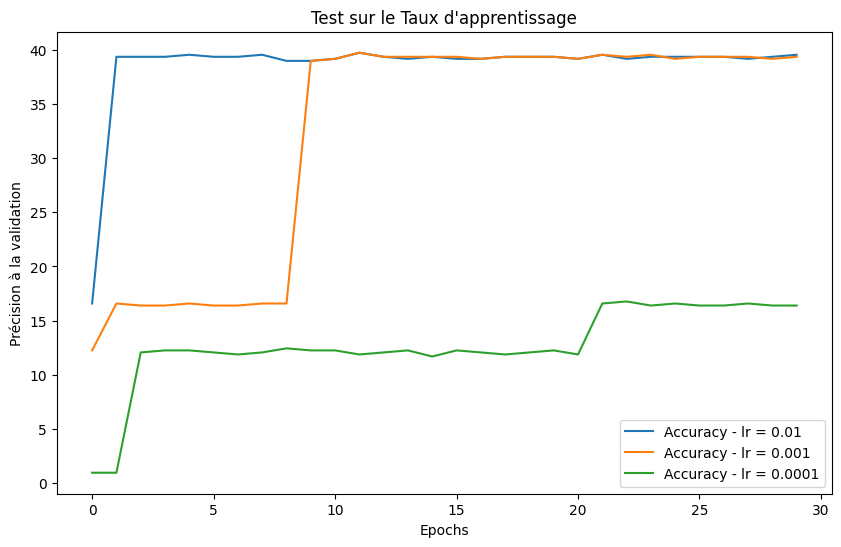

In [ ]:
plt.figure(figsize=(10, 6))

# Itération sur chaque taux d'apprentissage et son historique correspondant
for _, history in lr_history_dict.items():
    # Extraction des valeurs de l'accuracy
    training_acc = [epoch_metrics['val_acc'] for epoch_metrics in history]

    # Tracé de la courbe
    plt.plot(training_acc, label=f'Accuracy - lr = ' + str(lr_rates[int(_)]))

# Ajout de titres et de labels
plt.title('Test sur le Taux d\'apprentissage')
plt.xlabel('Epochs')
plt.ylabel('Précision à la validation')

# Affichage de la légende
plt.legend()

# Affichage du graphique
plt.show()

On peut conclure faire les remarques suivantes:

Taux d'apprentissage 0,01 (ligne bleue) : Le modèle avec un taux d'apprentissage de 0,01 commence avec la plus grande précision sur l'ensemble de validation, mais montre une baisse significative après les premières époques. Cela suggère que le taux d'apprentissage est peut-être trop élevé, ce qui amène le modèle à dépasser le point optimal dans le paysage des pertes après s'en être initialement approché.

Taux d'apprentissage 0,001 (ligne orange) : Avec un taux d'apprentissage plus faible de 0,001, la précision du modèle s'améliore régulièrement avant de plafonner. Ce comportement indique que le taux d'apprentissage est probablement plus approprié, permettant au modèle de converger vers une meilleure solution sans dépassement.

Taux d'apprentissage 0,0001 (ligne verte) : La précision du modèle ayant le taux d'apprentissage le plus faible (0,0001) augmente très lentement et reste nettement inférieure à celle des modèles ayant des taux d'apprentissage plus élevés. Cela suggère que le taux d'apprentissage est peut-être trop faible, ce qui fait que le modèle apprend trop lentement. Il pourrait avoir besoin de plus d'époques pour converger vers une meilleure solution, ou bénéficier d'un taux d'apprentissage légèrement plus élevé.

Sur la base de ces observations, le taux d'apprentissage de 0,001 semble le plus efficace des trois pour ce modèle et cet ensemble de données particuliers, car il conduit à une plus grande précision sans l'instabilité observée avec un taux d'apprentissage de 0,01.

#### 3.2.2 Explication du choix de la taille de la couche cachée

Pour déterminer la taille de la couche qui pourrait amener a de bon résultats, nous avons effectuer des tests sur trois tailles différents sélectionner la valeur optimale. Dans la cellule suivante, nous avons définit une liste de valeure pour la taille cachée à expérimenter. Un modèle est ensuite entraîné pour chaque valeur et on stocke l'historique dans le dictionnaire. Nous avons défini pour ces tests la valeur de l'epoch à 30 pour limiter le temps d'exécution.

In [ ]:
# Define hidden sizes to experiment with
hidden_sizes = [100, 300, 600]

# Dictionary to store the training history for each hidden size
hidden_sizes_history_dict = {}

# Train the model for each hidden size and store the history
for hidden_size in hidden_sizes:
  test_unidirectional_model = LSTMClassifier(input_size, hidden_size, embedding_layer, len(target_incident_type))
  optimizer = Adam(test_unidirectional_model.parameters(), lr=0.001)
  test_unidirectional_experiment = Experiment("model/unidirectional_lstm_classification_hs" + str(hidden_size), test_unidirectional_model, optimizer=optimizer, task="classification")
  hidden_sizes_history_dict[str(hidden_size)] = test_unidirectional_experiment.train(train_dataloader, dev_dataloader, epochs=30, disable_tensorboard=True)


Epoch:  1/30 Train steps: 20 Val steps: 5 1m59.50s loss: 2.184281 acc: 2.666667 fscore_macro: 0.006241 val_loss: 2.177052 val_acc: 2.636535 val_fscore_macro: 0.009414
Epoch 1: val_acc improved from -inf to 2.63653, saving file to model/unidirectional_lstm_classification_hs100/checkpoint_epoch_1.ckpt
Epoch:  2/30 Train steps: 20 Val steps: 5 44.74s loss: 2.165841 acc: 13.494950 fscore_macro: 0.047579 val_loss: 2.165106 val_acc: 39.548023 val_fscore_macro: 0.066266
Epoch 2: val_acc improved from 2.63653 to 39.54802, saving file to model/unidirectional_lstm_classification_hs100/checkpoint_epoch_2.ckpt
Epoch:  3/30 Train steps: 20 Val steps: 5 51.15s loss: 2.152117 acc: 38.949495 fscore_macro: 0.067229 val_loss: 2.151833 val_acc: 39.548023 val_fscore_macro: 0.066320
Epoch:  4/30 Train steps: 20 Val steps: 5 58.22s loss: 2.135302 acc: 39.030303 fscore_macro: 0.069173 val_loss: 2.138585 val_acc: 39.359699 val_fscore_macro: 0.062763
Epoch:  5/30 Train steps: 20 Val steps: 5 54.24s loss: 2.124

On affiche sur un graphe la précision (accuracy) obtenu:

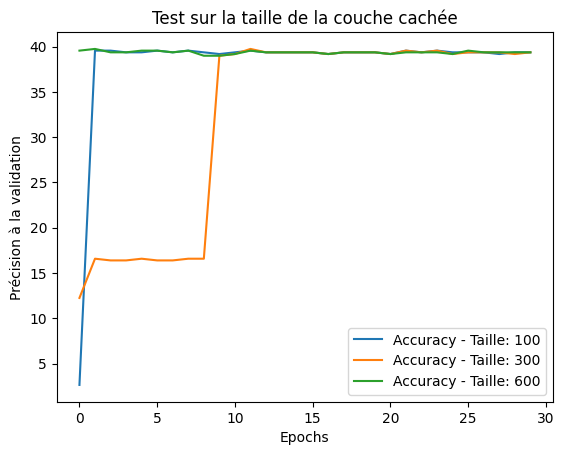

In [ ]:
for _, history in hidden_sizes_history_dict.items():
    training_loss = [epoch_metrics['val_acc'] for epoch_metrics in history]
    plt.plot(training_loss, label=f'Accuracy - Taille: ' + str(_))

plt.title('Test sur la taille de la couche cachée')
plt.xlabel('Epochs')
plt.ylabel('Précision à la validation')
plt.legend()
plt.show()

L'image ci-dessus montre le résultat des tests sur la taille de la couche cachée:

- **Couche cachée de taille 100** : La courbe bleue montre que la précision augmente rapidement au début, puis se stabilise à un niveau relativement bas par rapport aux autres modèles. Cela peut indiquer que la taille de 100 unités est trop petite pour capturer la complexité des données.

- **Couche cachée de taille 300** : La courbe orange indique une amélioration significative par rapport à la couche de taille 100. La précision augmente rapidement et atteint un plateau plus élevé, suggérant que cette taille de couche cachée est plus adéquate pour le modèle et les données en question.

- **Couche cachée de taille 600** : La courbe verte montre que la précision de validation commence à un niveau élevé et se maintient stable tout au long des époques, sans amélioration significative.

En résumé, le modèle avec une couche cachée de taille 300 semble offrir le meilleur compromis entre capacité du modèle et performance de validation. Une couche trop petite peut ne pas être suffisante pour apprendre les données, tandis qu'une couche trop grande peut conduire à de l'overfitting ou à un apprentissage inefficace.

### 3.3 Entrainement des modèles sur des paramètres optimales

In [ ]:
# Configuration optimale
batch_size = 128
input_size = nlp.meta['vectors']['width']
uni_learning_rate = 0.001
# Le taux d'apprentissage pour l'optimiseur du modèle LSTM bidirectionnel.
# Il est différent de celui du modèle unidirectionnel parce qu'après des tests, cette valeur a permis d'avor de meilleurs résultas
bi_learning_rate = 0.00001
hidden_size = 300
epochs = 50

In [ ]:
unidirectional_model = LSTMClassifier(input_size, hidden_size, embedding_layer, len(target_incident_type))
bidirectional_model = LSTMClassifier(input_size, hidden_size, embedding_layer, len(target_incident_type), True)

unid_optimizer = Adam(unidirectional_model.parameters(), lr=uni_learning_rate)
bidi_optimizer = Adam(bidirectional_model.parameters(), lr=bi_learning_rate)

unidirectional_experiment = Experiment('model/unidirectional_lstm_classification', unidirectional_model, optimizer= unid_optimizer, task="classification")
bidirectional_experiment = Experiment('model/bidirectional_lstm_classification', bidirectional_model, optimizer= bidi_optimizer, task="classification")

## 4. Fonctions utilitaires

Vous pouvez mettre ici toutes les fonctions qui seront utiles pour les sections suivantes.

## 5. Entraînement de modèle(s)

In [ ]:
uni_logging = unidirectional_experiment.train(train_dataloader, dev_dataloader, epochs=epochs, disable_tensorboard=True)

Epoch:  1/50 Train steps: 20 Val steps: 5 4m17.86s loss: 2.214171 acc: 11.313131 fscore_macro: 0.040982 val_loss: 2.204086 val_acc: 12.241055 val_fscore_macro: 0.025103
Epoch 1: val_acc improved from -inf to 12.24105, saving file to model/unidirectional_lstm_classification/checkpoint_epoch_1.ckpt
Epoch:  2/50 Train steps: 20 Val steps: 5 5m9.98s loss: 2.192867 acc: 12.727273 fscore_macro: 0.028349 val_loss: 2.191839 val_acc: 12.241055 val_fscore_macro: 0.027537
Epoch 2: val_acc improved from 12.24105 to 12.24105, saving file to model/unidirectional_lstm_classification/checkpoint_epoch_2.ckpt
Epoch:  3/50 Train steps: 20 Val steps: 5 5m5.07s loss: 2.179940 acc: 12.808081 fscore_macro: 0.029813 val_loss: 2.177822 val_acc: 12.052731 val_fscore_macro: 0.027148
Epoch:  4/50 Train steps: 20 Val steps: 5 5m34.89s loss: 2.161592 acc: 13.010101 fscore_macro: 0.032370 val_loss: 2.165869 val_acc: 12.241055 val_fscore_macro: 0.025144
Epoch:  5/50 Train steps: 20 Val steps: 5 5m20.17s loss: 2.15077

In [ ]:
bi_logging = bidirectional_experiment.train(train_dataloader, dev_dataloader, epochs=150, disable_tensorboard=True)

## 6. Évaluation et analyse de résultats

### 6.1 Modèle unidirectionnel

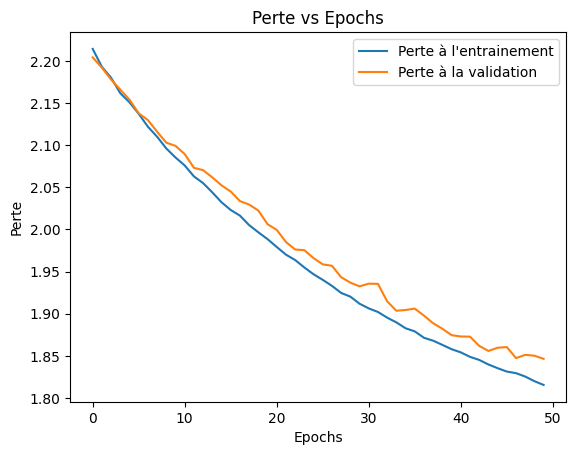

In [ ]:
plt.plot([epoch_metrics['loss'] for epoch_metrics in uni_logging], label=f'Perte à l\'entrainement')
plt.plot([epoch_metrics['val_loss'] for epoch_metrics in uni_logging], label=f'Perte à la validation')
plt.title('Perte vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()
plt.show()

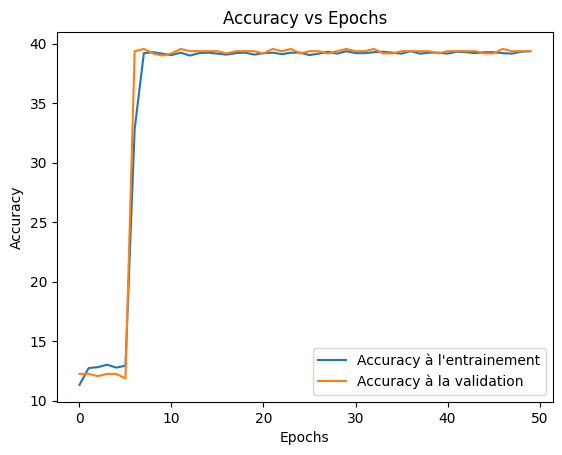

In [ ]:
plt.plot([epoch_metrics['acc'] for epoch_metrics in uni_logging], label=f'Accuracy à l\'entrainement')
plt.plot([epoch_metrics['val_acc'] for epoch_metrics in uni_logging], label=f'Accuracy à la validation')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Voici présenté sur un graphe, l'évolution de la perte et du accuracy à l'entrainement et à la validation

Le graphique indique que la précision sur les données d'entraînement (Accuracy à l'entrainement) et la précision sur les données de validation (Accuracy à la validation) augmentent de manière significative dès la première époque, avant de se stabiliser. La précision sur les deux ensembles de données devient presque parallèle après la première époque, avec des valeurs très proches l'une de l'autre. Cela indique que le modèle apprend efficacement dès le début et qu'il généralise bien. Cependant, après un test avec les même paramètres sur 500, la valeur de l'accuracy reste sensiblement identique au résultat sur le graphique. On peut donc conclure que le modèle a atteint sa capacité d'apprentissage optimale pour les données fournies. Cela signifie qu'il ne peut pas apprendre davantage des données d'entraînement, donc la poursuite de l'entraînement au-delà d'un certain point ne fait que consommer des ressources sans améliorer la performance

In [ ]:
unidirectional_experiment.test(test_dataloader)

Found best checkpoint at epoch: 8
lr: 0.001, loss: 2.10996, acc: 39.1919, fscore_macro: 0.071944, val_loss: 2.1159, val_acc: 39.548, val_fscore_macro: 0.0663517
Loading checkpoint model/unidirectional_lstm_classification/checkpoint_epoch_8.ckpt
Running test
Test steps: 5 7.01s test_loss: 2.124397 test_acc: 35.969868 test_fscore_macro: 0.058951         


{'time': 7.010862372000702,
 'test_loss': 2.1243970946403548,
 'test_acc': 35.969868223545916,
 'test_fscore_macro': 0.05895061790943146}

L'interprétation de ces résultats indique que le modèle n'atteint pas une performance élevée, comme en témoigne la précision inférieure à 40% sur les ensembles d'entraînement, de validation et de test. De même, les scores F macro, qui évaluent l'équilibre entre la précision et le rappel pour les classifications multiclass ou multilabel, sont également bas, indiquant que le modèle ne parvient pas à bien équilibrer la précision et le rappel pour toutes les classes.

Ces résultats peuvent provenir de plusieurs éléments dont:

**Complexité du modèle ou des données**: Le modèle pourrait être trop simple pour les données ou, inversement, les données pourraient être trop complexes ou bruyantes pour être bien capturées par le modèle.

**Qualité des données**: Les données pourraient ne pas être suffisamment informatives ou pourraient nécessiter un meilleur nettoyage ou prétraitement.

**Équilibrage des classes**: Si le dataset a des classes déséquilibrées, cela peut affecter le score F macro, surtout si le modèle n'est pas capable de bien identifier les classes minoritaires.


### 6.2 Modèle bi-directionnel

D'un autre coté, on peut observer sur le graphe suivant les performances du modèle bi-directionnel:

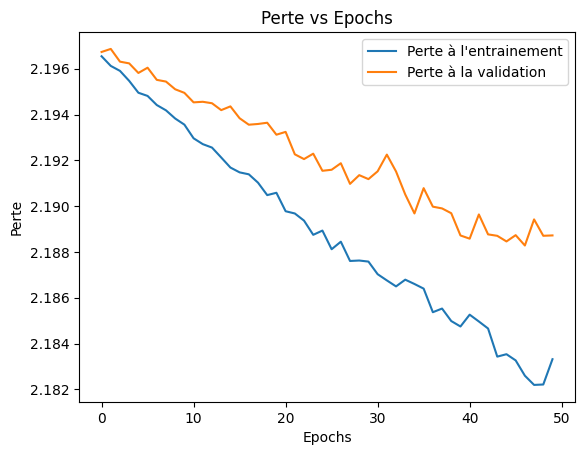

In [ ]:
plt.plot([epoch_metrics['loss'] for epoch_metrics in bi_logging], label=f'Perte à l\'entrainement')
plt.plot([epoch_metrics['val_loss'] for epoch_metrics in bi_logging], label=f'Perte à la validation')
plt.title('Perte vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()
plt.show()

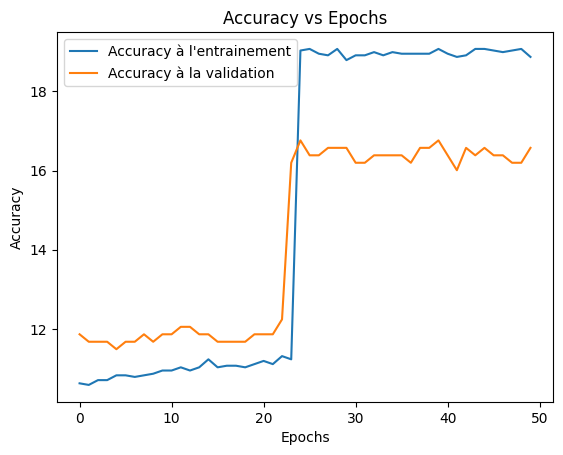

In [ ]:
plt.plot([epoch_metrics['acc'] for epoch_metrics in bi_logging], label=f'Accuracy à l\'entrainement')
plt.plot([epoch_metrics['val_acc'] for epoch_metrics in bi_logging], label=f'Accuracy à la validation')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Les deux images montrent les résultats du modèle LSTM bidirectionnel après l'entraînement, représentant la précision et la perte sur les données d'entraînement et de validation au fil des époques.

Dans la première image, montrant la précision, on observe que la précision sur les données d'entraînement est sensiblement plus élevée que sur les données de validation. Il y a également une variation significative de la précision de validation au fil des époques, ce qui pourrait indiquer une instabilité dans l'apprentissage ou une sensibilité aux particularités des données de validation.

Dans la deuxième image, qui illustre la perte, la perte diminue régulièrement sur les données d'entraînement, ce qui est un bon signe d'apprentissage. Cependant, la perte de validation ne diminue pas aussi régulièrement et présente des pics, ce qui pourrait suggérer que le modèle ne généralise pas aussi bien que souhaité.

Voici quelques conclusions possibles :

**Surajustement (Overfitting)**: La différence entre la précision d'entraînement et la précision de validation, avec des valeurs plus élevées pour l'entraînement, peut être un signe de surajustement. Le modèle peut apprendre des caractéristiques spécifiques aux données d'entraînement qui ne se généralisent pas bien aux données de validation.

**Volatilité de la validation**: La variation dans la précision de validation et les pics dans la perte de validation peuvent être dus à la nature des données de validation, certainement parce qu'elles ne sont pas équilibrées.

In [ ]:
bidirectional_experiment.test(test_dataloader)

Found best checkpoint at epoch: 40
lr: 1e-05, loss: 2.18475, acc: 19.0707, fscore_macro: 0.0437428, val_loss: 2.18872, val_acc: 16.7608, val_fscore_macro: 0.0335644
Loading checkpoint model/bidirectional_lstm_classification/checkpoint_epoch_40.ckpt
Running test
Test steps: 5 1.25s test_loss: 2.190521 test_acc: 19.209040 test_fscore_macro: 0.036036         


{'time': 1.2462249289965257,
 'test_loss': 2.1905208653200368,
 'test_acc': 19.209039546226602,
 'test_fscore_macro': 0.036036036908626556}

Après évaluation du modèle bi-directionel sur les données de test, on peut conclure que la performance du modèle sur l'ensemble de test est similaire à celle observée sur l'ensemble de validation, avec une précision légèrement supérieure sur l'ensemble de test. La précision globale est relativement basse, inférieure à 20%, ce qui signifie que le modèle a des difficultés à faire des prédictions correctes. De même, les scores F macro sont très faibles, ce qui suggère que le modèle a du mal à équilibrer la précision et le rappel pour toutes les classes, particulièrement dans les cas de classification multiclasse ou multilabel.

Ces métriques reflètent un modèle qui ne performe pas bien sur les tâches de classification avec les données actuelles. Cela peut être dû à plusieurs facteurs, tels que l'insuffisance des données, le besoin d'un prétraitement plus poussé, l'insuffisance de la complexité du modèle pour capturer les nuances des données, ou encore un déséquilibre dans la distribution des classes.

### 6.3 Évaluation générale

L'analyse des performances des modèles RNN unidirectionnels et bidirectionnels permet de tirer plusieurs conclusions :

   - Le modèle unidirectionnel a montré une précision de près de 40% sur l'ensemble de test, tandis que le modèle bidirectionnel a une précision d'environ 19% sur le même ensemble.
   - Cela indique que le modèle unidirectionnel a mieux généralisé à partir des données d'entraînement vers les données de test que le modèle bidirectionnel.